# Homework 11 (20pt)

In this assignment, you will apply an MLP/FFN (remember, multilayer perceptron and fully connected neural network mean the same thing) for handwritten digit recognition.

__Do not__ use datasets with preprocessed images in NumPy or Torch formats. You can either upload the data to Google Drive and mount it in Colab (so, you don't need to upload it every time), or download it manually from:  
https://www.kaggle.com/datasets/playlist/mnistzip/

Submit your Jupyter notebook, the saved model weights, and the images from the last question. You may submit multiple files or a single archived (e.g., `.zip`) file.


### Q1 (1pt) Download MNIST dataset

In [1]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: mnist_png/valid/4/8664.png  
  inflating: mnist_png/valid/4/8675.png  
  inflating: mnist_png/valid/4/8685.png  
  inflating: mnist_png/valid/4/8695.png  
  inflating: mnist_png/valid/4/8709.png  
  inflating: mnist_png/valid/4/8743.png  
  inflating: mnist_png/valid/4/8754.png  
  inflating: mnist_png/valid/4/8755.png  
  inflating: mnist_png/valid/4/8757.png  
  inflating: mnist_png/valid/4/8770.png  
  inflating: mnist_png/valid/4/8773.png  
  inflating: mnist_png/valid/4/8775.png  
  inflating: mnist_png/valid/4/8790.png  
  inflating: mnist_png/valid/4/8797.png  
  inflating: mnist_png/valid/4/8802.png  
  inflating: mnist_png/valid/4/881.png  
  inflating: mnist_png/valid/4/8812.png  
  inflating: mnist_png/valid/4/8822.png  
  inflating: mnist_png/valid/4/8829.png  
  inflating: mnist_png/valid/4/8832.png  
  inflating: mnist_png/valid/4/8836.png  
  inflating: mnist_png/valid/4/8861.png  
  inflating: mnist_png/val

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam
import pathlib
from tqdm import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter

### Q2 (2pt) Create Train and Validation Dataset and DataLoader objects

In [9]:
class MNIST_dataset(Dataset):
    def __init__(self, path_to_data):
        super().__init__()
        self.path_to_data = pathlib.Path(path_to_data)
        self.paths = list(self.path_to_data.rglob('*.png'))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img_path = self.paths[index].as_posix()
        label = int(img_path.split('/')[-2])
        image = read_image(img_path).float() / 255.0
        return image.squeeze(dim=0), torch.tensor(label)

In [10]:
# Create dataset objects with the correct paths
train_data = MNIST_dataset('mnist_png/train')
val_data = MNIST_dataset('mnist_png/valid')

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [11]:
# Check dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

Training set size: 60000
Validation set size: 10000


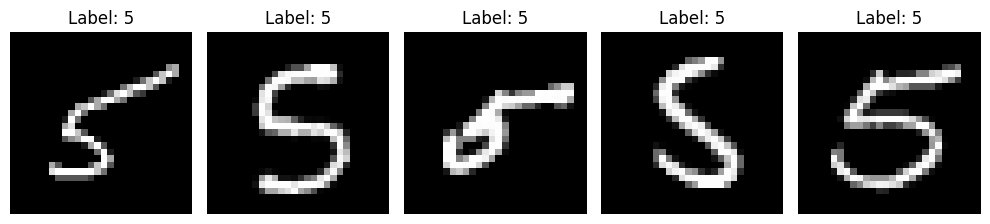

In [12]:
# Visualize a few images
plt.figure(figsize=(10, 5))
for i in range(5):
    img, label = train_data[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {label.item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Q3 (4pt) Define the model: the number of hidden layers and their size/dimentions. Make sure you are using __more than one hidden layer__

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [17]:
class MNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256), nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(0.2),
            nn.Linear(64, 10)
        )

    def forward(self, x): return self.model(x)

model = MNIST_MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
writer = SummaryWriter()

In [18]:
print(model)

MNIST_MLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=64, out_features=10, bias=True)
  )
)


### Q4 (4pt) Write the training loop. Use accuracy as the metric on the Validation set. You can use early stopping or just observe the validation curve

In [19]:
train_losses = []
val_accuracies = []
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/10"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    writer.add_scalar('Accuracy/validation', val_accuracy, epoch)

    print(f"Epoch {epoch+1}/10 - Loss: {avg_train_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # Save model if its the best so far
    if val_accuracy == max(val_accuracies):
        torch.save(model.state_dict(), 'best_model.pth')

writer.close()

Epoch 1/10: 100%|██████████| 938/938 [01:10<00:00, 13.35it/s]


Epoch 1/10 - Loss: 0.2936, Accuracy: 0.9650


Epoch 2/10: 100%|██████████| 938/938 [00:22<00:00, 41.88it/s]


Epoch 2/10 - Loss: 0.1512, Accuracy: 0.9735


Epoch 3/10: 100%|██████████| 938/938 [00:21<00:00, 42.76it/s]


Epoch 3/10 - Loss: 0.1188, Accuracy: 0.9712


Epoch 4/10: 100%|██████████| 938/938 [00:21<00:00, 43.18it/s]


Epoch 4/10 - Loss: 0.1040, Accuracy: 0.9768


Epoch 5/10: 100%|██████████| 938/938 [00:21<00:00, 42.64it/s]


Epoch 5/10 - Loss: 0.0950, Accuracy: 0.9797


Epoch 6/10: 100%|██████████| 938/938 [00:21<00:00, 43.89it/s]


Epoch 6/10 - Loss: 0.0869, Accuracy: 0.9785


Epoch 7/10: 100%|██████████| 938/938 [00:21<00:00, 44.08it/s]


Epoch 7/10 - Loss: 0.0820, Accuracy: 0.9797


Epoch 8/10: 100%|██████████| 938/938 [00:21<00:00, 43.89it/s]


Epoch 8/10 - Loss: 0.0769, Accuracy: 0.9793


Epoch 9/10: 100%|██████████| 938/938 [00:21<00:00, 43.27it/s]


Epoch 9/10 - Loss: 0.0695, Accuracy: 0.9821


Epoch 10/10: 100%|██████████| 938/938 [00:22<00:00, 41.82it/s]


Epoch 10/10 - Loss: 0.0661, Accuracy: 0.9825


### Q5 (2pt) Plot the training loss and validation accuracy. You can use Tensorboard

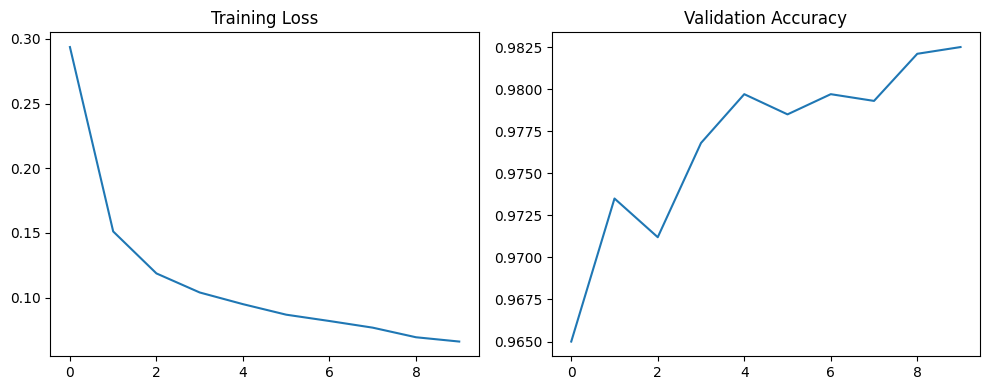

In [20]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

### Q6 (3pt) Calculate the accuracy on the validation set. __It should be > 0.97__

In [37]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_accuracy = correct / total
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

Final Validation Accuracy: 0.9825


### Q7 (4pt) Create three images, one with a digit not in the middle, and apply your trained model to them

In [59]:
# Create custom digits

def create_custom_digit(digit, off_center=False):
    img = torch.zeros((28, 28), dtype=torch.float32)
    center_x, center_y = (20, 10) if off_center else (14, 14)

    if digit == 0:
        for i in range(28):
            for j in range(28):
                if 4 < ((i - center_y) ** 2 + (j - center_x) ** 2) ** 0.5 < 7:
                    img[i, j] = 1.0
    elif digit == 1:
        for i in range(center_y - 7, center_y + 8):
            img[i, center_x] = 1.0
    elif digit == 3:
        for j in range(center_x - 3, center_x + 4):
            img[center_y - 7, j] = 1.0

        for j in range(center_x - 3, center_x + 4):
            img[center_y, j] = 1.0


        for j in range(center_x - 3, center_x + 4):
            img[center_y + 7, j] = 1.0

        for i in range(center_y - 7, center_y + 1):
            img[i, center_x + 3] = 1.0
        for i in range(center_y, center_y + 8):
            img[i, center_x + 3] = 1.0
    elif digit == 4:
        for i in range(center_y - 7, center_y + 8):
            img[i, center_x - 4] = 1.0
        for j in range(center_x - 4, center_x + 5):
            img[center_y, j] = 1.0
        for i in range(center_y - 7, center_y + 1):
            img[i, center_x + 4] = 1.0

    return img

custom_images = [
    create_custom_digit(1),
    create_custom_digit(4),
    create_custom_digit(3, off_center=False)
]

In [57]:
# Save custom images
for i, img in enumerate(custom_images):
    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.savefig(f"custom_digit_{i+1}.png")
    plt.close()

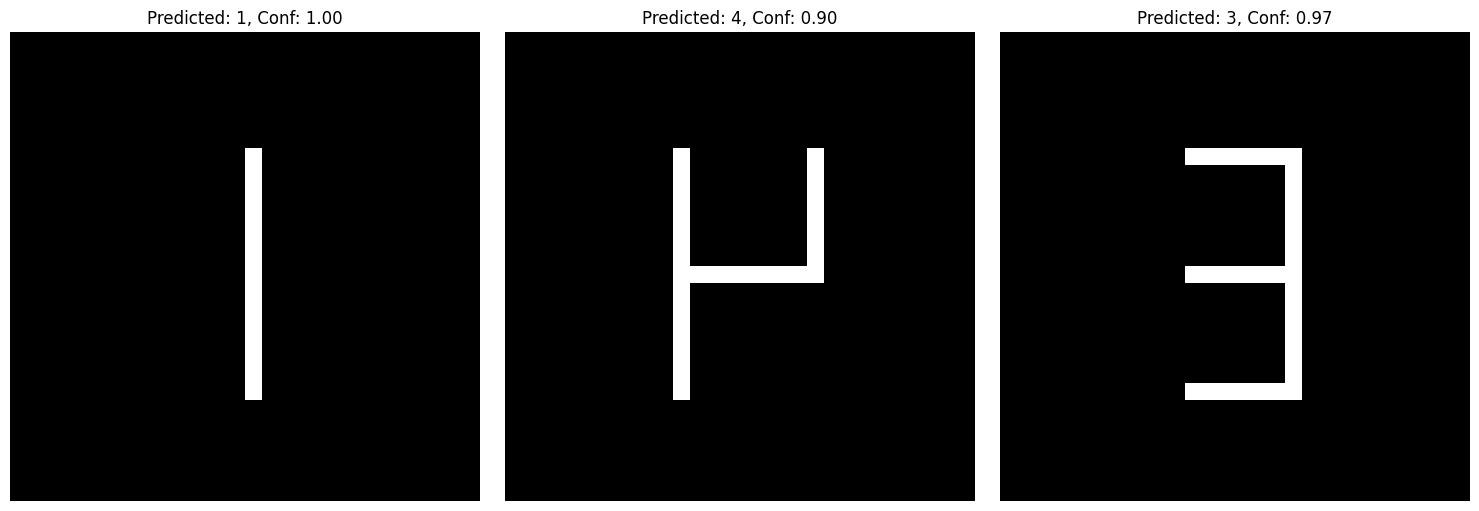

In [58]:
# Test custom images
model.eval()
plt.figure(figsize=(15, 5))

for i, img in enumerate(custom_images):
  x = img.unsqueeze(0).unsqueeze(0).to(device)
  with torch.no_grad():
      output = model(x)
      pred = torch.max(output.data, 1)[1].item()
      conf = torch.nn.functional.softmax(output, dim=1)[0][pred].item()

  plt.subplot(1, 3, i+1)
  plt.imshow(img, cmap='gray')
  plt.title(f"Predicted: {pred}, Conf: {conf:.2f}")
  plt.axis('off')

plt.tight_layout()
plt.savefig('custom_digit_predictions.png')
plt.show()